In [1]:
import numpy as np
import string

import nltk
print("PLEASE INSTALL all-corpora WHEN PROMPTED BY NLTK")
nltk.download()
print("YOU CAN THEN COMMENT OUT THE ABOVE LINE")
from nltk.corpus import stopwords
stop_words = stopwords.words("english")


## Preprocessing


What I did to reduce the number of words:

1. get rid of not alphanumeric letters from the text using Unix command
#sed "s/[^a-zA-Z]/ /g" training_data.txt > new_training_data.txt
2. Converted every word to lowercase.
3. Excluded stop words.
4. Removed words that appear fewer than 5 times. This allowed reducing the number of words from over 40000 to around 7500.



In [2]:
# Expand the stop word list to contain every single letters a, b ... z
alphabets = list(string.ascii_lowercase)
for al in alphabets:
    if al not in stop_words:
        stop_words.append(al)


datafile = open("./src/data_files/new_training_data.txt")
datafile_lines = [line.rstrip('\n') for line in datafile]


# Produce a set of unique words.
def get_unique_words(text=datafile_lines):

    words_dict = {}
    for sentence in datafile_lines:
        for word in sentence.split(" "):
            if word in words_dict:
                words_dict[word.lower()] += 1
            else:
                words_dict[word.lower()] = 1

    words_set = set()

    for w, count in words_dict.items():
        if count > 5:
            words_set.add(w)
          
    words_set = sorted(words_set)

    # Exclude stop words
    for word in words_set:
        if word in stop_words:
            words_set.remove(word)

    words_set_len = len(words_set)
    print("Size of the feature set: ", words_set_len) #7570
    
    return words_set

word_sets = get_unique_words()

# print( "\nBuilding dictionaries... ")
word2id = dict((w, i) for i, w in enumerate(word_sets))
id2word = dict((i, w) for i, w in enumerate(word_sets))
# print("complete!\n")


Number of unique words before stop words removed:  7658
Number of unique words cleaned:  7570

Building dictionaries... 
complete!



In [3]:
num_sentences = len(datafile_lines)
num_words = len(word_sets)

bag_of_words = np.zeros([num_sentences, num_words], dtype=np.int8)

In [4]:
# This function builds the bag of words model
def update_bag_of_words():
    for th, sentence in enumerate(datafile_lines):
        if th % 500 == 0:
            print("Processing... {}%, done!".format(th/num_sentences*100))
            
        lower_case_sentence = sentence.lower()
        words_in_sentence = lower_case_sentence.split()
        
        for word in words_in_sentence:

            if word in word_sets:
                ind = word2id[word]
                bag_of_words[th][ind] += 1
                
                
update_bag_of_words()

Processing... 0.0% done!
Processing... 1.6666666666666667% done!
Processing... 3.3333333333333335% done!
Processing... 5.0% done!
Processing... 6.666666666666667% done!
Processing... 8.333333333333332% done!
Processing... 10.0% done!
Processing... 11.666666666666666% done!
Processing... 13.333333333333334% done!
Processing... 15.0% done!
Processing... 16.666666666666664% done!
Processing... 18.333333333333332% done!
Processing... 20.0% done!
Processing... 21.666666666666668% done!
Processing... 23.333333333333332% done!
Processing... 25.0% done!
Processing... 26.666666666666668% done!
Processing... 28.333333333333332% done!
Processing... 30.0% done!
Processing... 31.666666666666664% done!
Processing... 33.33333333333333% done!
Processing... 35.0% done!
Processing... 36.666666666666664% done!
Processing... 38.333333333333336% done!
Processing... 40.0% done!
Processing... 41.66666666666667% done!
Processing... 43.333333333333336% done!
Processing... 45.0% done!
Processing... 46.666666666

## Perceptron & Average Perceptron

In [5]:
train_labels = np.loadtxt("./src/data_files/training_labels.txt",\
                          delimiter='\n', dtype=np.int32)

In [6]:
validation_datafile = open("./src/data_files/val_data.txt")
validation_datafile_lines = [line.rstrip('\n') for line in validation_datafile]

validation_labels = np.loadtxt("./src/data_files/val_labels.txt",\
                          delimiter='\n', dtype=np.int32)

In [7]:
num_validation_sentences = len(validation_datafile_lines)

validation_bag_of_words = np.zeros([num_validation_sentences, num_words], dtype=np.int8)

def update_validation_bag_of_words():
    for th, sentence in enumerate(validation_datafile_lines):
        if th % 500 == 0:
            print("Processing... {}%, done!".format(th/num_validation_sentences*100))
            
        lower_case_sentence = sentence.lower()
        words_in_sentence = lower_case_sentence.split()
        
        for word in words_in_sentence:

            if word in word_sets:
                ind = word2id[word]
                validation_bag_of_words[th][ind] += 1
            else:
                continue
                
update_validation_bag_of_words()

Processing... 0.0% done!
Processing... 5.0% done!
Processing... 10.0% done!
Processing... 15.0% done!
Processing... 20.0% done!
Processing... 25.0% done!
Processing... 30.0% done!
Processing... 35.0% done!
Processing... 40.0% done!
Processing... 45.0% done!
Processing... 50.0% done!
Processing... 55.00000000000001% done!
Processing... 60.0% done!
Processing... 65.0% done!
Processing... 70.0% done!
Processing... 75.0% done!
Processing... 80.0% done!
Processing... 85.0% done!
Processing... 90.0% done!
Processing... 95.0% done!


In [8]:
def shuffle_data():
    concat = np.c_[bag_of_words, train_labels]
    np.random.shuffle(concat)
    shuffled_bag_of_words = concat[:,:-1]
    shuffled_train_labels = concat[:,-1]
    return shuffled_bag_of_words, shuffled_train_labels

def update_weight(weights, sentence, true_label, prediction):
    error = true_label - prediction
    delta_weight = sentence * error
    learning_rate = 0.1
    return weights + learning_rate * delta_weight

def accuracy(data, labels, weights):
    predictions = np.matmul(data, weights)
    num_correct = 0
    for k, pred in enumerate(predictions):
        if pred >=0:
            pred = 1
        else:
            pred = 0
        if pred == labels[k]:
            num_correct += 1
    return num_correct / len(labels)

def perceptron(x=bag_of_words, y=train_labels):
    mean, standard_dev = 0, 0.1
    weights = np.random.normal(mean, standard_dev, num_words)
    weights_for_average_perceptron = np.random.normal(mean, standard_dev, num_words)
    
    #Keep track of training accuracies
    perceptron_train_accuracies = []
    averaged_perceptron_train_accuracies = []
    
    #keep track of validation accuracies
    perceptrion_validation_accuracies = []
    averaged_perceptron_validation_accuracies = []
    
    epochs = 51
    for t in range(epochs):
        if t % 10 ==0:
            print("Epoch #: ", t)
            
        x, y = shuffle_data()
        
        #Report training accuracies
        percep_acc = accuracy(bag_of_words, train_labels, weights)
        perceptron_train_accuracies.append(percep_acc)
        ave_percep_acc = accuracy(bag_of_words, train_labels, weights_for_average_perceptron)
        averaged_perceptron_train_accuracies.append(ave_percep_acc)
        
        #Report validation accuracies
        percep_val_acc = accuracy(validation_bag_of_words, validation_labels, weights)
        perceptrion_validation_accuracies.append(percep_val_acc)
        ave_percep_val_acc = accuracy(validation_bag_of_words, validation_labels, weights_for_average_perceptron)
        averaged_perceptron_validation_accuracies.append(ave_percep_val_acc)
        
        
        # In each epoch, iterate through every sentence, update weights
        for i in range(num_sentences):
            sentence = x[i] # bag of words of sentence i
            true_label = y[i] # corresponding weights

            weighted_sum_sentence = np.dot(sentence, weights)

            prediction = 0
            # if the prediction is correct, good
            if weighted_sum_sentence >= 0:
                prediction = 1
                
            # if incorrect, update weights
            if prediction != true_label:
                weights = update_weight(weights, sentence, true_label, prediction)
                weights_for_average_perceptron += weights
        
        weights_for_average_perceptron /= num_sentences
            
    return weights, weights_for_average_perceptron,\
            perceptron_train_accuracies, averaged_perceptron_train_accuracies,\
            perceptrion_validation_accuracies, averaged_perceptron_validation_accuracies

In [9]:
updated_weights, updated_weights_for_average_perceptron,\
perceptron_train_accuracies, averaged_perceptron_train_accuracies,\
perceptrion_validation_accuracies, averaged_perceptron_validation_accuracies\
= perceptron(bag_of_words, train_labels)

Epoch #:  0
Epoch #:  10
Epoch #:  20
Epoch #:  30
Epoch #:  40
Epoch #:  50
Epoch #:  60
Epoch #:  70
Epoch #:  80
Epoch #:  90
Epoch #:  100
Epoch #:  110
Epoch #:  120
Epoch #:  130
Epoch #:  140
Epoch #:  150


## Plot accuracy curves for train and validation datasets

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

### Accuracy plot for Perceptron on training data

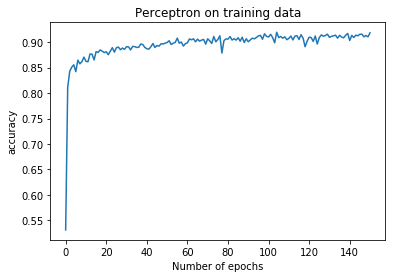

In [14]:
plt.plot(perceptron_train_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("accuracy")
plt.title("Perceptron on training data")
plt.show()

### Accuracy plot for Perceptron on validation data

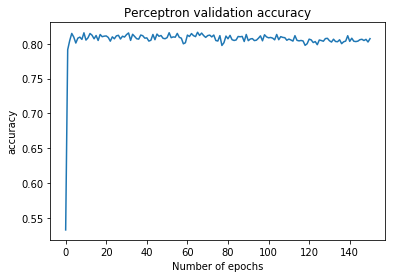

In [15]:
plt.plot(perceptrion_validation_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("accuracy")
plt.title("Perceptron validation accuracy")
plt.show()

### Accuracy plot for Averaged Perceptron on training data

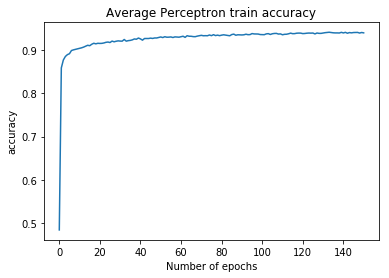

In [16]:
plt.plot(averaged_perceptron_train_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("accuracy")
plt.title("Average Perceptron train accuracy")
plt.show()

### Accuracy plot for Averaged Perceptron on validation data

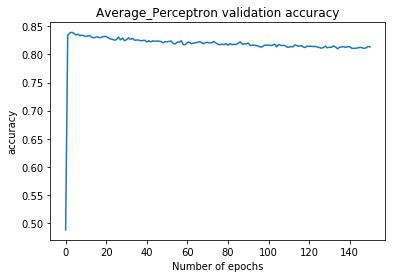

In [17]:
plt.plot(averaged_perceptron_validation_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("accuracy")
plt.title("Average_Perceptron validation accuracy")
plt.show()

## Make test predictions with Averaged Perceptron 

In [18]:
test_datafile = open("./src/data_files/test_data.txt")
test_datafile_lines = [line.rstrip('\n') for line in test_datafile]
num_test_sentences = len(test_datafile_lines)

test_bag_of_words = np.zeros([num_test_sentences, num_words], dtype=np.int8)


In [19]:
def update_test_bag_of_words():
    for th, sentence in enumerate(test_datafile_lines):
        if th % 500 == 0:
            print("Processing... {}, done!".format(th/num_test_sentences))
            
        lower_case_sentence = sentence.lower()
        words_in_sentence = lower_case_sentence.split()
        
        for word in words_in_sentence:

            if word in word_sets:
                ind = word2id[word]
                test_bag_of_words[th][ind] += 1
            else:
                continue
                
update_test_bag_of_words()

Processing sentence number:  0 0.0 done!
Processing sentence number:  500 0.05 done!
Processing sentence number:  1000 0.1 done!
Processing sentence number:  1500 0.15 done!
Processing sentence number:  2000 0.2 done!
Processing sentence number:  2500 0.25 done!
Processing sentence number:  3000 0.3 done!
Processing sentence number:  3500 0.35 done!
Processing sentence number:  4000 0.4 done!
Processing sentence number:  4500 0.45 done!
Processing sentence number:  5000 0.5 done!
Processing sentence number:  5500 0.55 done!
Processing sentence number:  6000 0.6 done!
Processing sentence number:  6500 0.65 done!
Processing sentence number:  7000 0.7 done!
Processing sentence number:  7500 0.75 done!
Processing sentence number:  8000 0.8 done!
Processing sentence number:  8500 0.85 done!
Processing sentence number:  9000 0.9 done!
Processing sentence number:  9500 0.95 done!


In [26]:
test_predictions = np.matmul(test_bag_of_words, updated_weights_for_average_perceptron)
for l, t_pred in enumerate(test_predictions):
    if t_pred >= 0:
        test_predictions[l] = 1
    else:
        test_predictions[l] = 0

In [27]:
def save_test_predictions():
    np.savetxt("/Users/hyunjaecho/Desktop/NLP_proj1/submit_files", test_predictions, fmt='%.0f')
    
save_test_predictions()